# Transfer Learning

Inspired by: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb

In [39]:
# imports

from typing import List, Tuple  # for type hints

import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import plotly.express as px  # for plots
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization
import torch.nn as nn 
import torch.nn.functional as F
import torchmetrics
import os
import datasets
from livelossplot import PlotLosses
from sentence_transformers.util import pairwise_angle_sim

from mteb import MTEB

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [40]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 1. Load and process input data

In [41]:
def unnest(ds) -> list[datasets.Dataset]:
    dss = []
    for v in ds.values():
        if not isinstance(v, datasets.Dataset):
            dss.extend(unnest(v))
        else:
            dss.append(v)
    return dss

def load_dataset_for_task(task_name: str):
    mteb = MTEB(tasks=[task_name], task_langs=["en"])
    task = mteb.tasks[0]
    task.load_data()
    assert task.data_loaded, "Data was not loaded"
    return datasets.concatenate_datasets([*unnest(task.dataset)])

def process_dataset(dataset: datasets.Dataset) -> pd.DataFrame:
    train_df = dataset.to_pandas()
    train_df = train_df[['sentence1', 'sentence2', 'score']]
    def normalize(x, min_score, max_score): # Norm between 0 and 1
        zero_one = (x - min_score) / (max_score - min_score)
        scaled_down = zero_one 
        return scaled_down 
    train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())
    return train_df

In [42]:
TASKS = [
    "BIOSSES",
    # "SICK-R",
    "STS12",
    "STS13",
    "STS14",
    "STS15",
    "STS16",
    "STS17",
    "STS22",
    "STSBenchmark",
]

dfs = {}
for task_name in TASKS:
    print("Loading task:", task_name)
    dataset = load_dataset_for_task(task_name)
    df_task = process_dataset(dataset)

    dfs[task_name] = df_task



Loading task: BIOSSES
Loading task: STS12
Loading task: STS13
Loading task: STS14
Loading task: STS15
Loading task: STS16
Loading task: STS17


/cs/student/projects3/COMP0087/grp4/damien_code/.venv/lib64/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for mteb/sts17-crosslingual-sts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mteb/sts17-crosslingual-sts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading task: STS22


/cs/student/projects3/COMP0087/grp4/damien_code/.venv/lib64/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for mteb/sts22-crosslingual-sts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mteb/sts22-crosslingual-sts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading task: STSBenchmark


## 2. Generate Synthetic Data

In [43]:
# TODO (Look at generating for dissimilar data cause all of them seem to be similar)

## 3. Get Embeddings and Cosine Similarities

In [44]:
from model_factory import model_factory
model_name = 'angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage'

In [45]:
def generate_embedding(df: pd.DataFrame, model_name: str, task_name: str):
    model = model_factory(model_name, task_name)
    for column in ['sentence1', 'sentence2']:
        df[f"{column}_embedding"] = model.encode(df[column].tolist())

def get_cosine_similarity(a: np.array, b: np.array):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def generate_cosine_similarity(df: pd.DataFrame):
    df['cosine_similarity'] = df.apply(lambda x: get_cosine_similarity(x['sentence1_embedding'], x['sentence2_embedding']), axis=1)

In [46]:
for task_name, df in dfs.items():
    generate_embedding(df, model_name, task_name)
    generate_cosine_similarity(df)


Creating model angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage for task BIOSSES
Loading angle from cache for BIOSSES...
Loading cohere from cache for BIOSSES...
Loading flag-embedding from cache for BIOSSES...
Loading gist from cache for BIOSSES...
Loading gte-large from cache for BIOSSES...
Loading llmrails from cache for BIOSSES...
Loading mixed-bread from cache for BIOSSES...
Loading voyage from cache for BIOSSES...
Creating model angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage for task STS12
Loading angle from cache for STS12...
Loading cohere from cache for STS12...
Loading flag-embedding from cache for STS12...
Loading gist from cache for STS12...
Loading gte-large from cache for STS12...
Loading llmrails from cache for STS12...
Loading mixed-bread from cache for STS12...
Loading voyage from cache for STS12...
Creating model angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage for task STS13
Loading angle from cache 

In [47]:
# Combine all the dataframes
df = pd.concat(dfs.values(), ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Split the data
df_train, df_val = train_test_split(df, test_size=0.2, random_state=seed)

# Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_train

,sentence1,sentence2,score,sentence1_embedding,sentence2_embedding,cosine_similarity
0,us ups pressure on israel as un demands gaza t...,"us , un up pressure on israel over gaza",0.8000,"[0.015081810812526419, -0.009523711094214108, ...","[0.016756128839932598, -0.006453406863435107, ...",0.912226
1,A squirrel is spinning around in circles.,A squirrel runs around in circles.,0.8000,"[0.008319213192451883, -0.0014437571243336865,...","[0.010036054016985875, 0.00020944258341149498,...",0.937144
2,"There is an urgent need, following the recent ...",The recent incidents against the Greek minorit...,1.0000,"[-0.007894522166984977, 0.006227656471342738, ...","[-0.00991423872996868, 0.0021652997737864775, ...",0.961837
3,"In the latest top-level shuffle at CNN, Teya R...","In CNN's latest move to rejuvenate ratings, th...",0.7538,"[-0.006125870821686028, -0.0036590676400611367...","[-0.005952355799176715, -0.0015707695399312205...",0.902555
4,English works everywhere with people buying an...,I traveled around Maharashtra (including Mumba...,0.5600,"[-0.010519128453944683, 0.0050985698593002966,...","[-0.013080164771787322, 0.004153407833559348, ...",0.622848
...,...,...,...,...,...,...
19157,a man jumps off of one rooftop onto another .,a young man jumps from one balcony to another .,0.5600,"[-0.004699748991303104, 0.011214719288655719, ...","[-0.011206285675128817, 0.010318647383164514, ...",0.875979
19158,there must be a balance as a whole .,the unity must be in balance .,0.8000,"[-0.003132480120127307, 0.00556591065792563, -...","[-0.0027157856088153407, -0.007820945938376785...",0.867467
19159,Ukrainian President orders 7-day ceasefire in ...,Uganda's President Museveni agrees to sign ant...,0.0400,"[-0.0065350919208285955, 0.0021809286202436285...","[-0.00792452869861471, -0.01538245623018225, -...",0.480831
19160,nytimes : ? mad men ? set to return on april 7...,artsbeat : ' mad men ' set to return on april 7,0.9200,"[0.006549051222975912, -0.005366573323852497, ...","[0.008099545515286482, -0.002648396807298974, ...",0.872061


## 4. Evaluate The Baseline Performance

We use spearman and Pearson to evaluate the performance. 

Pearson correlation is a measure of strength of linear relationship between two variables. It ranges from -1 to 1.

While spearman correlation is a measure of monotonic relationship between two variables. It ranges from -1 to 1.

We want both these values to be close to 1. 


In [48]:
def get_correlation(df: pd.DataFrame, column_name: str = 'cosine_similarity'):
    return df[column_name].corr(df['score'], method='spearman'), df[column_name].corr(df['score'], method='pearson')

spearmans, pearsons = get_correlation(df_train)
print(f"Train: Spearman: {spearmans}, Pearson: {pearsons}")

spearmans, pearsons = get_correlation(df_val)
print(f"Validation: Spearman: {spearmans}, Pearson: {pearsons}")

Train: Spearman: 0.8774928028855264, Pearson: 0.8826597266655919
Validation: Spearman: 0.8798110492199028, Pearson: 0.8837822481909154


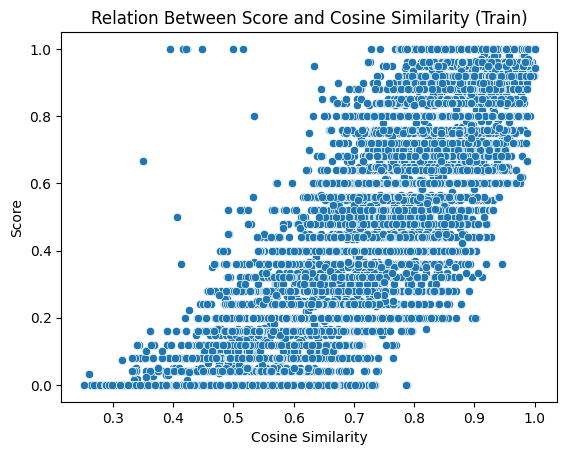

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df: pd.DataFrame, title: str):
    sns.scatterplot(data=df, x='cosine_similarity', y='score')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Score')
    plt.show()

plot_correlation(df_train, 'Relation Between Score and Cosine Similarity (Train)')

# 5. Preprocessing before training



In [50]:
def get_tensors(df):
    df_x1 = np.stack(df['sentence1_embedding'].values)
    df_x2 = np.stack(df['sentence2_embedding'].values)
    df_y = df['score'].values

    X1 = torch.from_numpy(df_x1).float()
    X2 = torch.from_numpy(df_x2).float()
    Y = torch.from_numpy(df_y).float()
    return X1, X2, Y
    
X1_train, X2_train, Y_train = get_tensors(df_train)
X1_val, X2_val, Y_val = get_tensors(df_val)

# Move everything to the device
X1_train = X1_train.to(device)
X2_train = X2_train.to(device)
Y_train = Y_train.to(device)

X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
Y_val = Y_val.to(device)

# 6. Transfer Learning

Defining our Model

In [51]:
class LinearTransformationModel(torch.nn.Module):
    def __init__(self, embedding_dim: int, embedding_output_dim: int, dropout_rate: float = 0.1):
        super(LinearTransformationModel, self).__init__()
        self.linear = torch.nn.Linear(embedding_dim, embedding_output_dim)
        self.dropout = torch.nn.Dropout(dropout_rate) # dropout should be first or after?
    
    def forward(self, x: torch.Tensor):
        x = self.dropout(x)
        x = self.linear(x)
        return x

class ElementwiseProductModel(torch.nn.Module):
    def __init__(self, embedding_dim):
        super(ElementwiseProductModel, self).__init__()
        self.params = nn.Parameter(torch.ones(embedding_dim))

    def forward(self, x):
        return x * self.params
    
class StackWiseProductModel(torch.nn.Module):
    def __init__(self, stack_size):
        super(StackWiseProductModel, self).__init__()
        assert stack_size > 1, "Stack size must be greater than 1"
        self.stack_size = stack_size
        self.params = nn.Parameter(torch.ones(stack_size))

    def weights(self):
        return F.softmax(self.params, dim=0)

    def forward(self, x):
        # Make sure they some to one to prevent possible explosion
        weights = self.weights()
        for i in range(self.stack_size):
            j = i * 1024
            x[:, j:(j+1024)] *= weights[i]
        return x

In [52]:
class CosineSimilarityModel(torch.nn.Module):
    def __init__(self, transformation_model: torch.nn.Module):
        super(CosineSimilarityModel, self).__init__()
        self.transformation_model = transformation_model
    
    def forward(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor):
        embedding1_custom = self.transformation_model(embeddings1)
        embedding2_custom = self.transformation_model(embeddings2)
        return torch.nn.functional.cosine_similarity(embedding1_custom, embedding2_custom, dim=1)

class AnglEModel(torch.nn.Module):
    def __init__(self, transformation_model: torch.nn.Module, scale: float = 20.0):
        super(AnglEModel, self).__init__()
        self.transformation_model = transformation_model
        self.scale = scale
    
    def forward(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor):
        scores = pairwise_angle_sim(self.transformation_model(embeddings1), self.transformation_model(embeddings2))
        return scores


Possible Loss Functions

In [53]:
def mse_loss(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    lossF = torch.nn.MSELoss()
    return lossF(cosine_similarity, scores)

def spearman_correlation(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    spearman_corr = torchmetrics.SpearmanCorrCoef().to(device)
    return spearman_corr(cosine_similarity, scores)

def pearson_correlation(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    pearson_corr = torchmetrics.PearsonCorrCoef().to(device)
    return pearson_corr(cosine_similarity, scores)

def angle_loss(scores: torch.Tensor, labels: torch.Tensor, scale: float = 20.0):
    scores = scores * scale
    scores = scores[:, None] - scores[None, :]

    labels = labels[:, None] < labels[None, :]
    labels = labels.float()

    scores = scores - (1 - labels) * 1e12

    scores = torch.cat((torch.zeros(1).to(device), scores.view(-1)), dim=0)
    loss = torch.logsumexp(scores, dim=0)
    return loss

Training Loop

In [54]:
def train_one_epoch(model, training_loader, optimizer, loss_function = None):
    running_loss = 0.

    for X1, X2, Y in training_loader:
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        cosine_sim = model(X1, X2)
        loss = loss_function(cosine_sim, Y)
        
        # Compute the loss and its gradients
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Record the loss
        running_loss += loss.item()

    average_loss = running_loss / len(training_loader)
    return average_loss


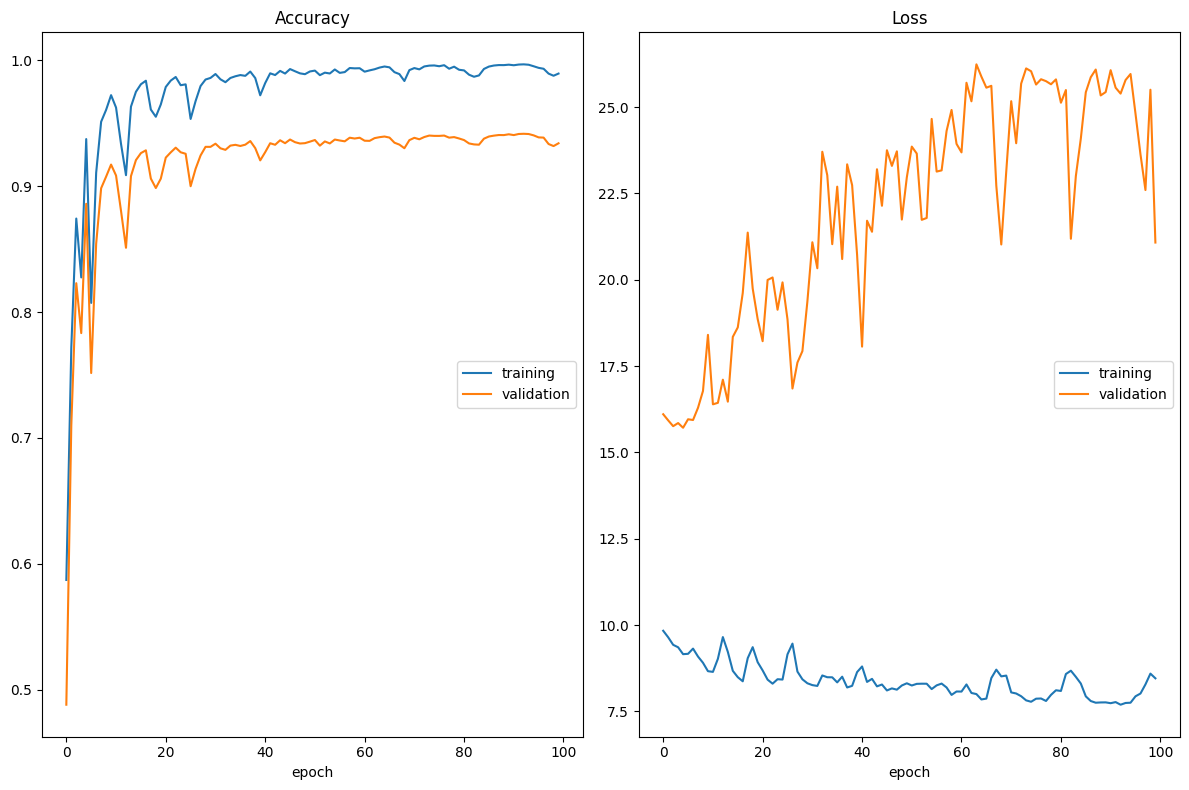

Accuracy
	training         	 (min:    0.587, max:    0.997, cur:    0.989)
	validation       	 (min:    0.488, max:    0.942, cur:    0.934)
Loss
	training         	 (min:    7.694, max:    9.835, cur:    8.458)
	validation       	 (min:   15.713, max:   26.236, cur:   21.076)


In [55]:
out_dir = 'test_results'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Hyperparameters
max_epochs = 100
lr = 0.001
batch_size = 200

# Loss function
# loss_function = mse_loss
loss_function = angle_loss

# Model
transformation_model = LinearTransformationModel(1024 * 8, 1024, dropout_rate=0.1)
# transformation_model = ElementwiseProductModel(1024 * 8)
# transformation_model = StackWiseProductModel(8)

# model = CosineSimilarityModel(transformation_model)
# model = model.to(device)

model = AnglEModel(transformation_model)
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Data Loader
train_dataset = torch.utils.data.TensorDataset(X1_train, X2_train, Y_train)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Keep track of losses
plotlosses = PlotLosses()

model.train()
best_val_loss = float('inf')
for _ in range(max_epochs):
    epoch_loss = train_one_epoch(model, training_loader, optimizer, loss_function)

    # Additional metrics for performance tracking
    model.eval()
    with torch.no_grad():
        # Generate the validation loss
        val_predictions = model(X1_val, X2_val)
        val_loss = loss_function(val_predictions, Y_val).item()

        # Save locally if it is the best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({'transformation_model': model.transformation_model}, f"{out_dir}/best_model.pth")

        # Compute the correlations
        train_spearman = spearman_correlation(model(X1_train, X2_train), Y_train).item()
        val_spearman = spearman_correlation(val_predictions, Y_val).item()
    model.train()

    plotlosses.update({'loss': epoch_loss, 'val_loss': val_loss, 'acc': train_spearman, 'val_acc': val_spearman})
    plotlosses.send()

torch.save({'transformation_model': model.transformation_model}, f"{out_dir}/final_model.pth")

# 7. Evaluation

Load from memory

In [56]:
state_dict = torch.load(f"test_results/final_model.pth")
transformation_model = state_dict["transformation_model"].to(device)
model = CosineSimilarityModel(transformation_model)

In [57]:
model.eval()
with torch.no_grad():
    val_predictions = model(X1_val, X2_val)
    val_loss = mse_loss(val_predictions, Y_val).item()
    val_spearman = spearman_correlation(val_predictions, Y_val).item()
    val_pearson = pearson_correlation(val_predictions, Y_val).item()

print(f"Validation Loss: {val_loss}, Validation Spearman: {val_spearman}, Validation Pearson: {val_pearson}")    

Validation Loss: 0.05989519879221916, Validation Spearman: 0.9074760675430298, Validation Pearson: 0.8966057300567627
